# Crevasse model over a parameter space
This note book looks in detail at individual solutions.  Another notebook looks at ensembles of solutions over different parts of the parameter space.

In [1]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [2]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams.update({'font.size': 16})

from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import multiprocessing
from functools import partial
from scipy.optimize import fminbound

import crevasse as c # main module for this project
from importlib import reload
reload(c)

<module 'crevasse' from '/home/bradlipovsky/notebooks/Near-Front-Crevasses/crevasse.py'>

### Define baseline parameters

In [3]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

### Analytical solutions

In [4]:
Lcs = np.logspace(np.log10(5),np.log10(50e3),50)
r = mats['rho']/mats['rhow']

D, flexural_gravity_wavelength,lam = c.fgl(mats,geom)
KI_analytical, KI_analytical_bottom = c.analytical_KI(geom,mats)
KI_analytical_bending,KI_analytical_bending_bottom = c.analytical_KI_bending(geom,mats,Lcs)

# Calculate surface and bottom crevasse sifs for a range of locations
Or, if this has already been done, just load them from a file instead.

In [5]:
run_names = ('bottom','surface')

for this_run in run_names:

    filename = '%s-crevasse-sifs.pkl'%this_run
    
    if path.exists(filename):
        print('The simulation "%s" has already been run and saved. \n\
        To be safe, rename this file if you want to re-run.'%this_run)

    else:
        KIs = []
        KIIs = []

        g = geom

        t1_start = perf_counter() 
        for Lci in Lcs:
            g['Lc']=Lci
            these_Ks = c.sif(g,mats,verbose=False,loc='bottom')
            KIs.append(these_Ks[0])
            KIIs.append(these_Ks[1])
        t1_stop = perf_counter() 
        print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)

        KIs = np.array(KIs)
        KIIs = np.array(KIIs)

        sifs = {'KI':KIs, 'KII':KIIs}

        with open(filename, 'wb') as f:
            pickle.dump(sifs, f)

The simulation "bottom" has already been run and saved. 
        To be safe, rename this file if you want to re-run.
The simulation "surface" has already been run and saved. 
        To be safe, rename this file if you want to re-run.


# Plot SIFs as a function of distance from the ice front

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


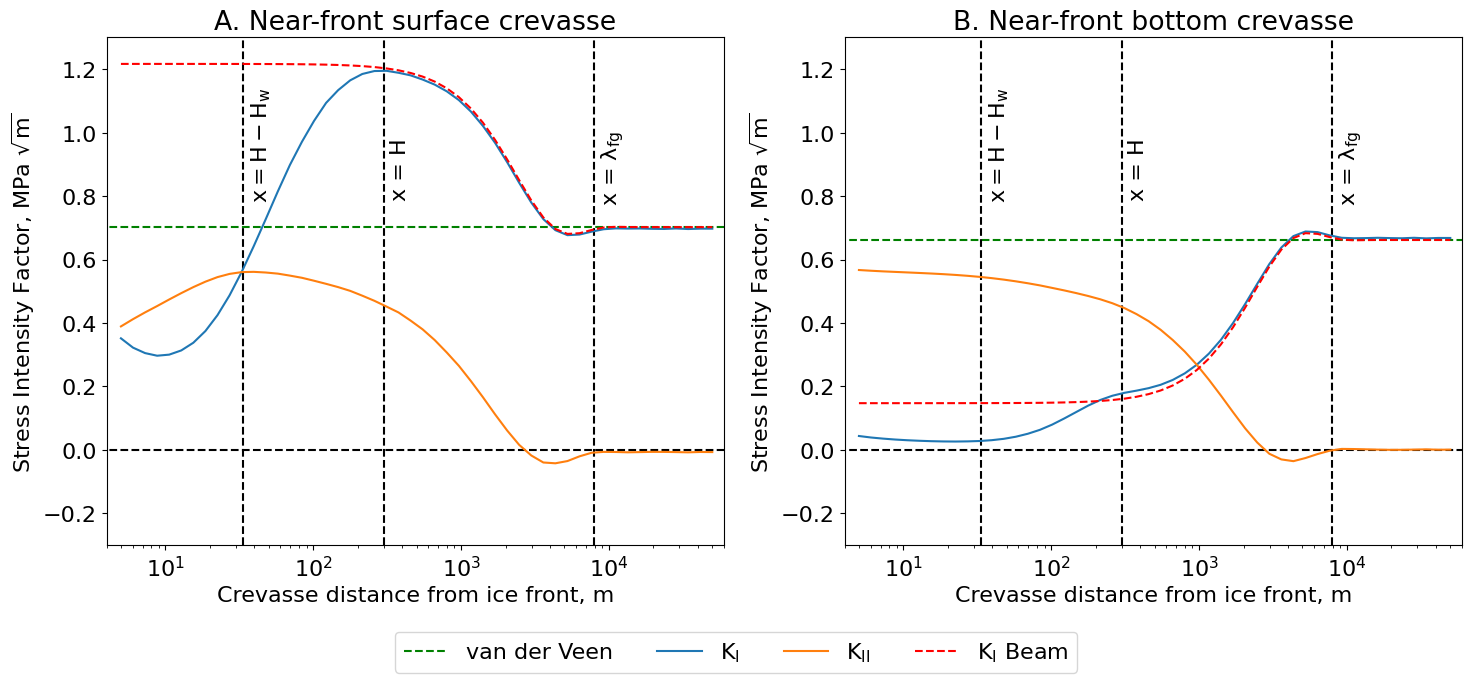

In [6]:
with open('surface-crevasse-sifs.pkl', 'rb') as f:
    surface_sifs = pickle.load(f)
with open('bottom-crevasse-sifs.pkl', 'rb') as f:
    bottom_sifs = pickle.load(f)

ymax = 1.3
ymin = -0.3
haf = geom['H'] - mats['rho']/mats['rhow'] * geom['H']

fig,ax=plt.subplots(1,2,figsize=(15,7))


ax=plt.subplot(1,2,1)
plt.plot([0,100e3],KI_analytical*np.ones(2)/1e6,'--g',label='van der Veen')
plt.plot([0,100e3],[0,0],'--k')
plt.plot(geom['H']*np.ones(2),[ymin, ymax],'--k')
plt.plot(flexural_gravity_wavelength*np.ones(2),[ymin, ymax],'--k')
plt.plot(haf*np.ones(2),[ymin, ymax],'--k')
plt.plot(Lcs,surface_sifs['KI']/1e6,'-',label='$K_I$')
plt.plot(Lcs,surface_sifs['KII']/1e6,'-',label='$K_{II}$')
plt.plot(Lcs,KI_analytical_bending,'--r',label='$K_I$ Beam')
ax.set_ylim([ymin, ymax])
ax.set_xlim([4,60e3])
# plt.legend(loc='lower left')
plt.xscale('log')

ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
ax.text(haf*1.1, 0.8, '$x = H-H_w$', rotation=90)
ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = $\lambda_{fg}$', rotation=90)

plt.xlabel('Crevasse distance from ice front, m')
plt.ylabel('Stress Intensity Factor, MPa $\sqrt{m}$')
plt.title('A. Near-front surface crevasse')

ax=plt.subplot(1,2,2)
plt.plot([0,100e3],KI_analytical_bottom*np.ones(2)/1e6,'--g')
plt.plot([0,100e3],[0,0],'--k')
plt.plot(geom['H']*np.ones(2),[ymin, ymax],'--k')
plt.plot(flexural_gravity_wavelength*np.ones(2),[ymin, ymax],'--k')
plt.plot(haf*np.ones(2),[ymin, ymax],'--k')
plt.plot(Lcs,bottom_sifs['KI']/1e6,'-')
plt.plot(Lcs,bottom_sifs['KII']/1e6,'-')
plt.plot(Lcs,KI_analytical_bending_bottom,'--r')
ax.set_ylim([ymin, ymax])
ax.set_xlim([4,60e3])
plt.xscale('log')
ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
ax.text(haf*1.1, 0.8, '$x = H-H_w$', rotation=90)
ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = $\lambda_{fg}$', rotation=90)
plt.xlabel('Crevasse distance from ice front, m')
plt.ylabel('Stress Intensity Factor, MPa $\sqrt{m}$')
plt.title('B. Near-front bottom crevasse')

fig.legend(loc='lower center',ncol=4) #
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)   
plt.savefig('figures/sif-variation-in-x.eps', format='eps')

# Plot surface and bottom crevasse SIFs with swell

In [71]:
def make_spatial_figure(output_min,output_max,Lcs_swell,
                        save=False,draw_analytical=True,ylim=[-0.25,1.6]):
    labels=('Basal $K_I$','Surface $K_{I}$','Basal $K_{II}$','Surface $K_{II}$')
    letters=('A. ', 'B. ', 'C. ','D. ')
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))

    for i,this_ax in enumerate((ax1,ax2,ax3,ax4)):

        if i==0:
            sif_no_swell = bottom_sifs['KI']/1e6
        elif i ==1:
            sif_no_swell = surface_sifs['KI']/1e6
        if i==2:
            sif_no_swell = bottom_sifs['KII']/1e6
        elif i ==3:
            sif_no_swell = surface_sifs['KII']/1e6

        sif_no_swell_interp = np.interp(Lcs_swell,Lcs,sif_no_swell)
        swell_min = np.array(output_min[i])[:,1]/1e6
        swell_max = np.array(output_max[i])[:,1]/1e6

        this_ax.fill_between(Lcs_swell/1e3, swell_max, swell_min, 
                             color="lightgray", label='Swell Range')
        this_ax.plot(Lcs/1e3,sif_no_swell,label=labels[i],color='k',linewidth=2)
        this_ax.plot((0,20),(0.1,0.1),'--',label='Nominal Fracture Toughness of Ice',color='k')

        this_ax.set_xlim([0e3,flexural_gravity_wavelength*2/1e3])
        this_ax.set_ylim(ylim)
        
        this_ax.set_ylabel('Stress Intensity Factor, MPa $\sqrt{m}$', fontsize=16)
        this_ax.set_xlabel('Distance From Ice Front, km', fontsize=16)
        
        this_ax.set_title(letters[i]+labels[i]+' Stress Intensity Factors', fontsize=20)

        axes2 = this_ax.twiny()
        axes2.set_xticks([0,0.5,1,1.5,2])
        axes2.set_xlabel('Distance / Flexural Gravity Wavelength', fontsize=16)
        axes2.grid(False)

    fig.tight_layout()
    fig.legend(['SIF without Swell', 'Nominal Fracture Toughness', 'Swell range'],loc='lower center',ncol=3)
    fig.subplots_adjust(bottom=0.15)   
    if save:
        plt.savefig('figures/sif-variation-with-swell.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


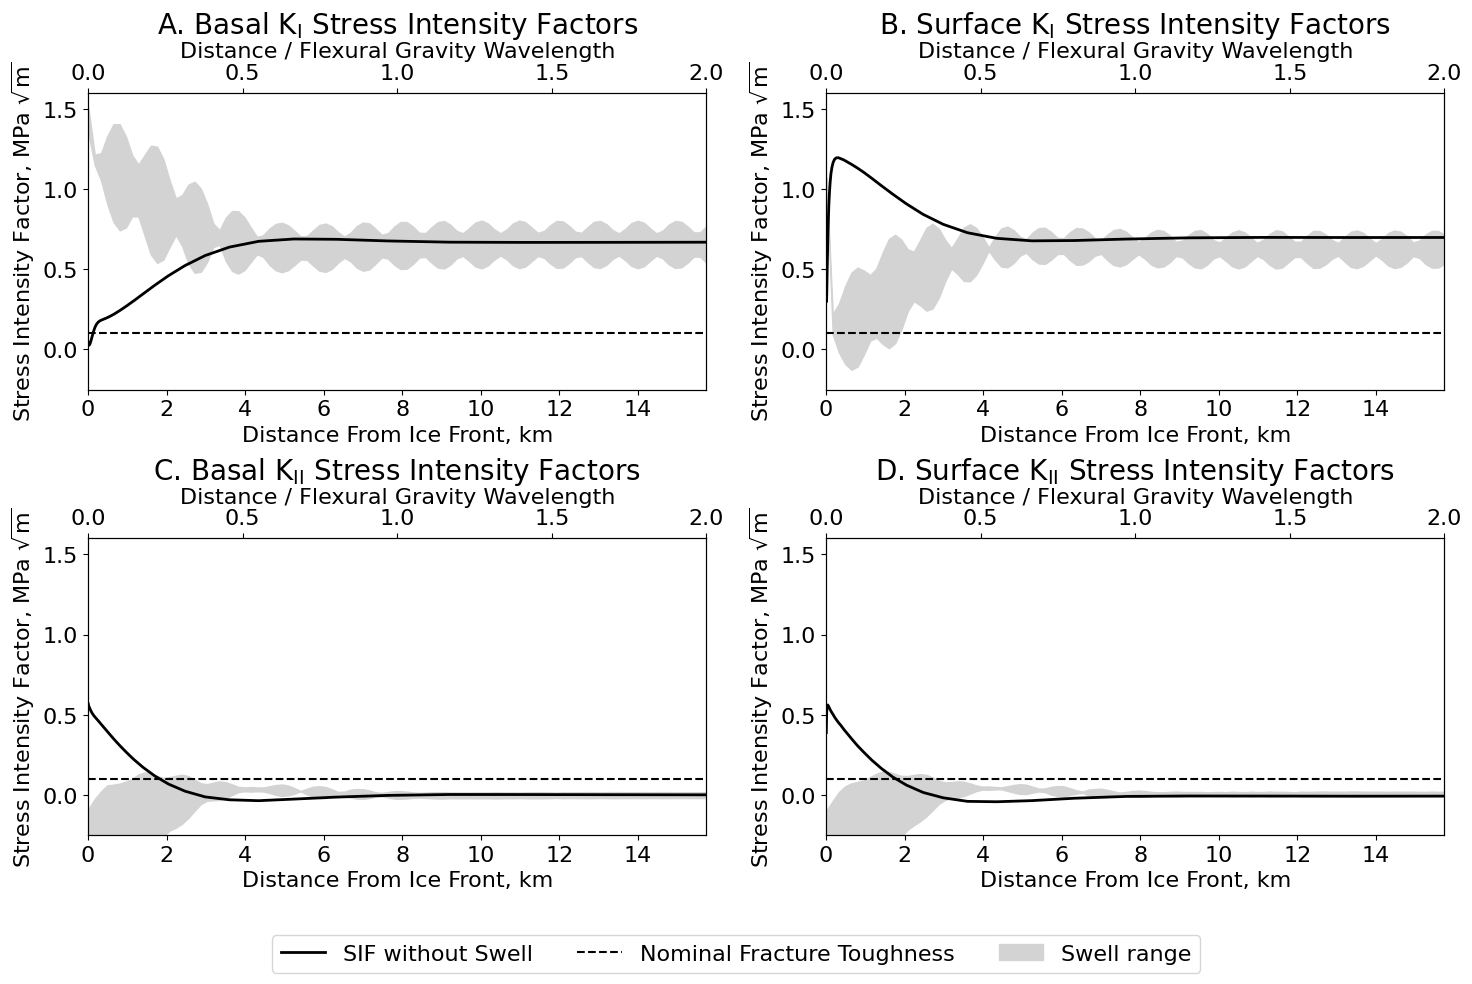

In [70]:
# The code to calculate swell sifs has been moved to run_crevasse_simulations.py

with open('swell-sifs-min.pkl', 'rb') as f:
    output_min = pickle.load(f)
    
with open('swell-sifs-max.pkl', 'rb') as f:
    output_max = pickle.load(f)
    
# with open('swell-sifs-med-res-linear-bottom-only.pkl', 'rb') as f:
#     output_bottom_only = pickle.load(f)

Lcs_swell = np.linspace(10,2*flexural_gravity_wavelength,100)

make_spatial_figure(output_min,output_max,Lcs_swell,save=True)

# Let's dig into the spatial pattern of the SIFs a little bit more.  
##  What causes the beating battern in the Surface SIFs?
To investigate: lets run a simulation with only the basal boundary condition but without the ice front boundary condition

Conclusion: the beating pattern is due to two processes:
1. The ice front boundary condition.  This boundary condition is what causes the beating pattern outside of the zone of flexure.
2. The bottom boundary condition. This boundary condition causes the beating pattern in KI near the ice front.  I suppose this is due to the phase of the forcing applied over the flexure zone.

0.09615484399878739


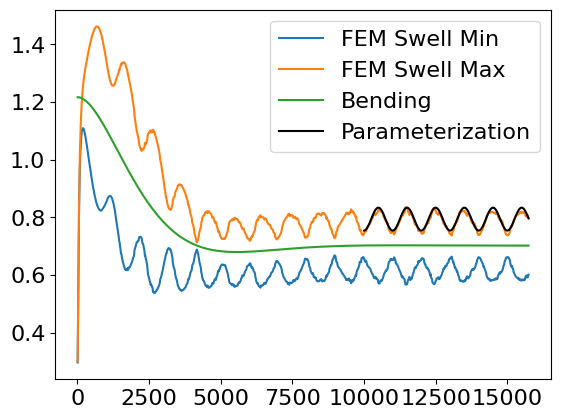

In [9]:
sif_no_swell = surface_sifs['KI']/1e6
sif_no_swell_interp = np.interp(Lcs_swell,Lcs,sif_no_swell)
swell_min = np.array(output_min[1])[:,1]/1e6
swell_max = np.array(output_max[1])[:,1]/1e6
swell_min_bottom_only = np.array(output_bottom_only[0])[:,1]/1e6
# swell_max = 2*sif_no_swell_interp-np.array(output[0])[:,1]/1e6

KI_analytical_bending,KI_analytical_bending_bottom = c.analytical_KI_bending(geom,mats,Lcs_swell)
sif_from_front = -mats['rhow']*mats['g']*np.cos(2*np.pi*Lcs_swell/1e3)/1e6 * np.sqrt(np.pi*geom['Hc'])

I = geom['H']**3 / 12
P = mats['rho']*mats['g']
f = 0.0232
M_flex = f * P * lam**2 / 4
stress_from_bottom = M_flex * geom['H'] / I 

sif_from_bottom = stress_from_bottom * 1.12 * \
                    np.sqrt( np.pi*geom['Hc'] ) / 1e6

#     M_flex = m0 * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) + np.sin(Lcs/lam))
#     sig_flex = M_flex * geom['H']/2 / II 

print(sif_from_bottom)

parameterization = sif_no_swell_interp[-1] + sif_from_front + sif_from_bottom

van_der_veen = sif_no_swell_interp[-1] * np.ones_like(sif_no_swell_interp)

wave_parameterization = 3*mats['rhow']*mats['g']*1.0 * \
                            1.12 * np.sqrt( np.pi*geom['Hc'] ) / 1e6

simplified_model =  KI_analytical_bending + wave_parameterization

fig,ax=plt.subplots()
# plt.plot(Lcs_swell,sif_no_swell_interp-KI_analytical/1e6)

plt.plot(Lcs_swell,swell_min,label='FEM Swell Min')
plt.plot(Lcs_swell,swell_max,label='FEM Swell Max')
# plt.plot(Lcs_swell, (swell_min-1*swell_max)/2 , label='(Max+Min)/2')

plt.plot(Lcs_swell,KI_analytical_bending,'-',label='Bending')
plt.plot(Lcs_swell[Lcs_swell>10e3],parameterization[Lcs_swell>10e3],
         '-k', label='Parameterization')
# plt.plot(Lcs_swell,simplified_model,'--',label='Simplified model')

# plt.ylim([-0.1,1.5])
# plt.xscale('log')
# plt.xlim([0,5000])
plt.legend()

# plt.plot(Lcs_swell,KI_analytical*np.ones_like(Lcs_swell)/1e6,'--')
# plt.plot(Lcs_swell,KI_analytical*np.ones_like(Lcs_swell)/1e6 - .12,'--')

# Footloose

In [14]:
with open('fl-swell-sifs-low-res-linear-max.pkl', 'rb') as f:
    output_fl_max = pickle.load(f)
with open('fl-swell-sifs-low-res-linear-min.pkl', 'rb') as f:
    output_fl_min = pickle.load(f)

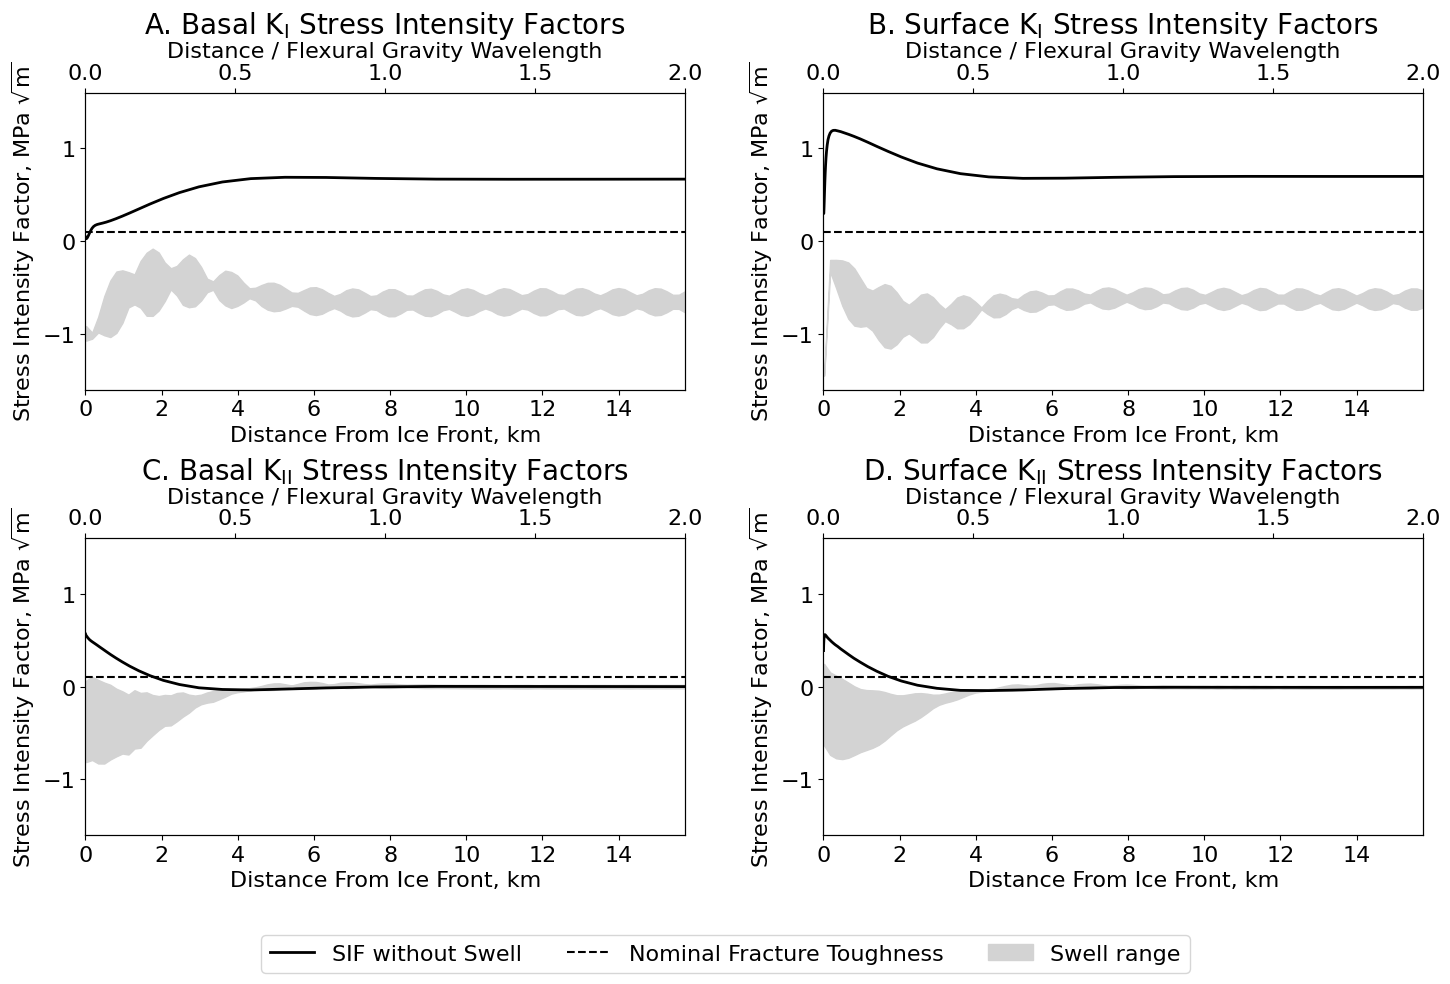

In [21]:
fl_lcs_swell  = np.linspace(20,2*flexural_gravity_wavelength,100)
make_spatial_figure(output_fl_min,output_fl_max,fl_lcs_swell,
                   ylim=[-1.6,1.6])


In [75]:
with open('swell-sifs.pkl', 'rb') as f:
    output_swell = pickle.load(f)

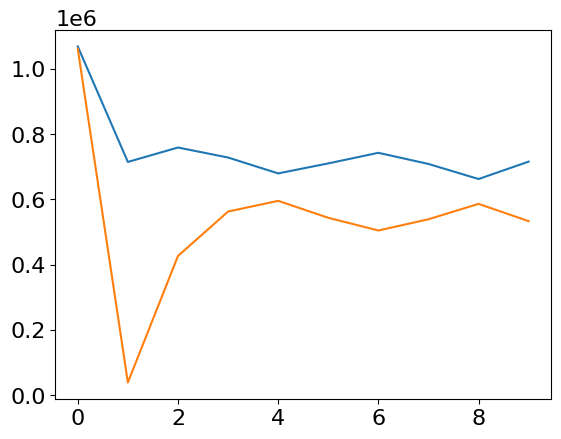

In [92]:
plt.figure()
plt.plot( - np.array(output_swell['surface KI min'])[:,1] )
plt.plot( - np.array(output_swell['surface KI max'])[:,1] )

array([1.5167682 , 3.33318748, 3.98206889, 5.71252159, 1.20154908,
       3.62473667, 4.71981047, 5.82062618, 1.69643771, 3.65462208])